In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, average_precision_score, PrecisionRecallDisplay, recall_score, f1_score, precision_recall_curve, auc, classification_report, confusion_matrix, make_scorer, fbeta_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
import shap
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

In [159]:
df_train=pd.read_csv('../data/output/development_sample_cleaned_1.csv')
df_test=pd.read_csv('../data/output/testing_sample_cleaned.csv')

In [221]:
df_train=pd.read_csv('../data/output/countinuous_dfs/development_sample_cleaned_continuous.csv')
df_test=pd.read_csv('../data/output/countinuous_dfs/testing_sample_cleaned_continuous.csv')

In [3]:
df_train=pd.read_csv('../data/output/categorical_dfs/development_sample_cleaned_categorical.csv')
df_test=pd.read_csv('../data/output/categorical_dfs/testing_sample_cleaned_categorical.csv')

In [189]:
df_train=pd.read_csv('../data/output/categorical_dfs/development_sample_woe.csv')
df_test=pd.read_csv('../data/output/categorical_dfs/testing_sample_woe.csv')

In [145]:
df_train = df_train.drop(['ID', 'customer_id'], axis=1)
df_test = df_test.drop(['ID', 'customer_id'], axis=1)

KeyError: "['ID', 'customer_id'] not found in axis"

In [190]:
# Separate features and target variable
X = df_train.drop('target', axis=1)
y = df_train['target']


In [191]:
X_t = df_test.drop('target', axis=1)
y_t = df_test['target']

In [219]:
oversamplers = {
    'SMOTE': SMOTE(random_state=123),
    'RandomOverSampler': RandomOverSampler(random_state=123)
    #'ADASYN': ADASYN(random_state=123),
    #'RandomUnderSampler': RandomUnderSampler(random_state=123),
    #'NearMiss': NearMiss(version=1, n_neighbors=3)
}

# Define the parameters for GridSearchCV
param_grid = {
    'C': [0.9, 1, 1.1],
    'penalty': ['l1','l2'],
    'solver': ['liblinear','saga'],
    # set class weight
    'class_weight': [None]
}

In [193]:
def pr_auc_score(y_true, y_pred):
    # Compute PR_AUC using average_precision_score
    pr_auc = average_precision_score(y_true, y_pred)
    return pr_auc

# Create a scorer from the custom scoring function
pr_auc_scorer = make_scorer(pr_auc_score)




In [194]:
f05_scorer = make_scorer(fbeta_score, beta=2)


In [217]:
param_grid_catboost = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'auto_class_weights': ['None', 'Balanced'],
}

In [220]:
results_dict_catboost = {}
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_t_scaled = scaler.transform(X_t)

for name, oversampler in oversamplers.items():
    # Upsample the minority class using the current oversampler
    X_resampled, y_resampled = oversampler.fit_resample(X_train_scaled, y_train)
    
    # Initialize CatBoost classifier
    catboost_clf = CatBoostClassifier(random_state=123, verbose=0)
    
    # Initialize GridSearchCV with CatBoost and verbose for detailed progress
    grid_search = GridSearchCV(catboost_clf, param_grid_catboost, cv=3, scoring='roc_auc', n_jobs=-1, verbose=4)
    
    # Fit GridSearchCV on the training data
    grid_search.fit(X_resampled, y_resampled)
    
    # Get the best parameters
    best_params_catboost = grid_search.best_params_
    print(f"\nBest Parameters for {name} with RFE:", best_params_catboost)
    
    # Store results in dictionary
    results_catboost = pd.DataFrame(grid_search.cv_results_)
    cols_to_keep_catboost = ['param_iterations', 'param_learning_rate', 'param_depth', 'param_l2_leaf_reg', 'param_auto_class_weights', 'mean_test_score', 'std_test_score']
    results_table_catboost = results_catboost[cols_to_keep_catboost].sort_values(by='mean_test_score', ascending=False)
    results_dict_catboost[name] = results_table_catboost
    
    # Get the best performing model
    best_catboost_model = CatBoostClassifier(**best_params_catboost, random_state=123, verbose=0)
    best_catboost_model.fit(X_resampled, y_resampled)
    
    # Print classification report
    print("\nClassification Report with CatBoost:")
    y_pred_catboost = best_catboost_model.predict(X_t_scaled)
    print(classification_report(y_t, y_pred_catboost))
    
    # Plot Confusion Matrix
    cm_catboost = confusion_matrix(y_t, y_pred_catboost)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_catboost, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix with CatBoost')
    plt.show()
    
    # Calculate AUC-ROC
    y_prob_catboost = best_catboost_model.predict_proba(X_t_scaled)[:, 1]
    auc_roc_catboost = roc_auc_score(y_t, y_prob_catboost)
    print(f"\nAUC-ROC Score with CatBoost: {auc_roc_catboost}")
    
    # Plot AUC-ROC Curve
    fpr_catboost, tpr_catboost, thresholds_catboost = roc_curve(y_t, y_prob_catboost)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_catboost, tpr_catboost, label=f"AUC-ROC Score: {auc_roc_catboost:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve with CatBoost')
    plt.legend(loc="lower right")
    plt.show()

# Combine results for all oversamplers into a single table
combined_results_catboost = pd.concat(results_dict_catboost, axis=1)

# Print the combined results
print("\nCombined Results for all Oversamplers with RFE (CatBoost Classifier):")
print(combined_results_catboost)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


KeyboardInterrupt: 

In [213]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

Fitting 3 folds for each of 80 candidates, totalling 240 fits

Best Parameters for RandomUnderSampler with RFE: {'algorithm': 'auto', 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}

Classification Report with KNN:
              precision    recall  f1-score   support

         0.0       0.98      0.71      0.83      3427
         1.0       0.06      0.56      0.11       119

    accuracy                           0.71      3546
   macro avg       0.52      0.64      0.47      3546
weighted avg       0.95      0.71      0.80      3546



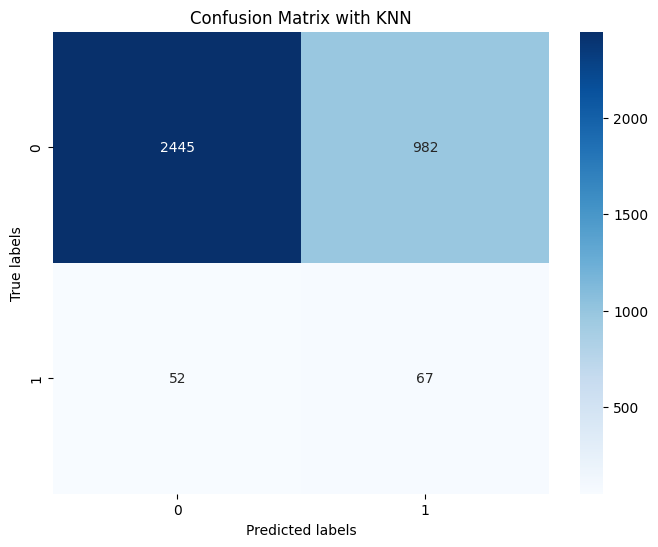


AUC-ROC Score with KNN: 0.7022753075551784


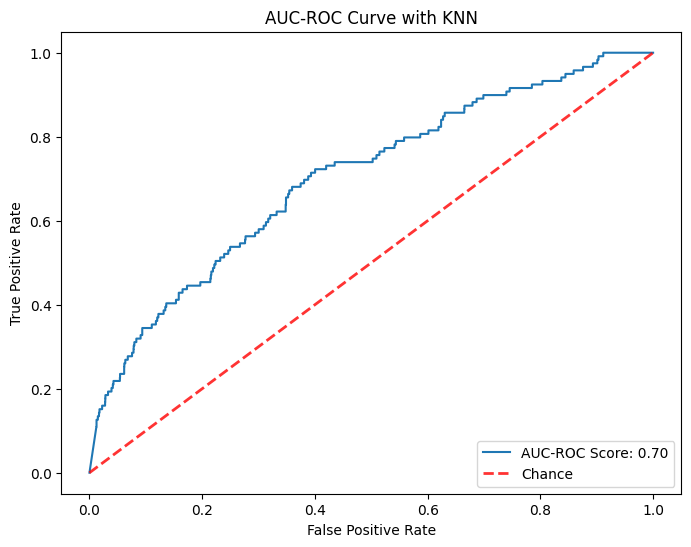

Fitting 3 folds for each of 80 candidates, totalling 240 fits

Best Parameters for NearMiss with RFE: {'algorithm': 'auto', 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}

Classification Report with KNN:
              precision    recall  f1-score   support

         0.0       0.97      0.35      0.51      3427
         1.0       0.04      0.72      0.07       119

    accuracy                           0.36      3546
   macro avg       0.50      0.53      0.29      3546
weighted avg       0.94      0.36      0.50      3546



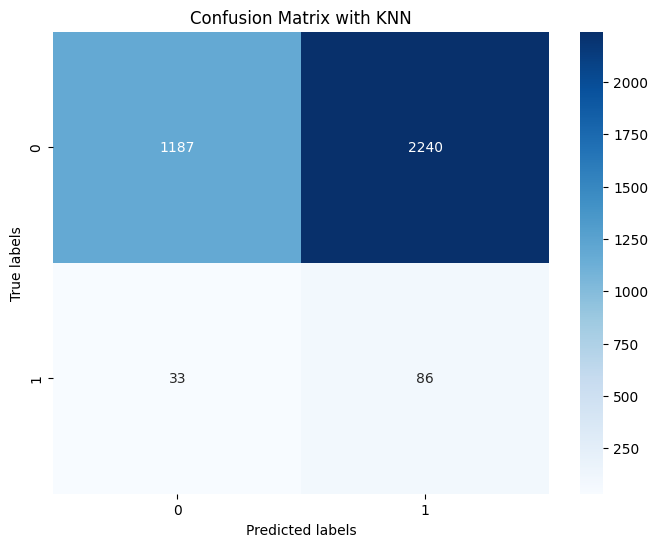


AUC-ROC Score with KNN: 0.5760593703486647


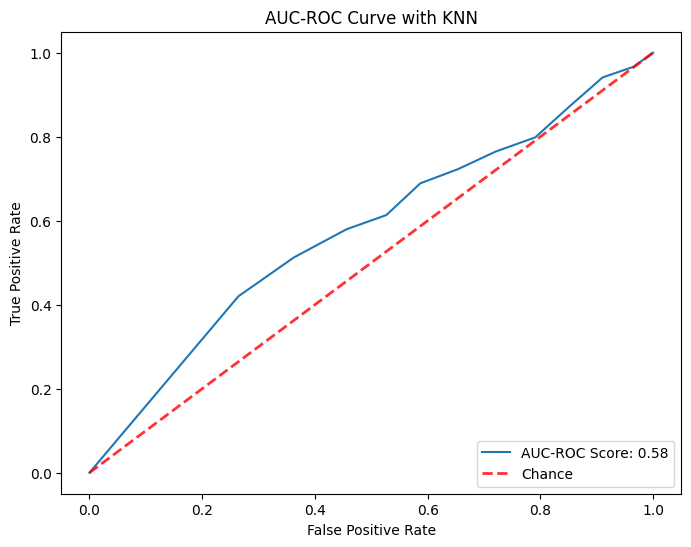


Combined Results for all Oversamplers with RFE (KNN Classifier):
   RandomUnderSampler                                                        \
    param_n_neighbors param_weights param_algorithm param_p mean_test_score   
79                 11      distance           brute       2        0.739569   
59                 11      distance         kd_tree       2        0.739569   
39                 11      distance       ball_tree       2        0.739569   
19                 11      distance            auto       2        0.739569   
18                 11       uniform            auto       2        0.737835   
..                ...           ...             ...     ...             ...   
42                  3       uniform         kd_tree       2        0.695670   
0                   3       uniform            auto       1        0.695230   
60                  3       uniform           brute       1        0.695230   
20                  3       uniform       ball_tree       1      

In [214]:
results_dict_knn = {}
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_t_scaled = scaler.transform(X_t)

for name, oversampler in oversamplers.items():
    # Upsample the minority class using the current oversampler
    X_resampled, y_resampled = oversampler.fit_resample(X_train_scaled, y_train)
    
    # Initialize KNN classifier
    knn_clf = KNeighborsClassifier()
    
    # Initialize GridSearchCV with KNN and verbose for detailed progress
    grid_search = GridSearchCV(knn_clf, param_grid_knn, cv=3, scoring='roc_auc', n_jobs=-1, verbose=4)
    
    # Fit GridSearchCV on the training data
    grid_search.fit(X_resampled, y_resampled)
    
    # Get the best parameters
    best_params_knn = grid_search.best_params_
    print(f"\nBest Parameters for {name} with RFE:", best_params_knn)
    
    # Store results in dictionary
    results_knn = pd.DataFrame(grid_search.cv_results_)
    cols_to_keep_knn = ['param_n_neighbors', 'param_weights','param_algorithm','param_p', 'mean_test_score', 'std_test_score']
    results_table_knn = results_knn[cols_to_keep_knn].sort_values(by='mean_test_score', ascending=False)
    results_dict_knn[name] = results_table_knn
    
    # Get the best performing model
    best_knn_model = KNeighborsClassifier(**best_params_knn)
    best_knn_model.fit(X_resampled, y_resampled)
    
    # Print classification report
    print("\nClassification Report with KNN:")
    y_pred_knn = best_knn_model.predict(X_t_scaled)
    print(classification_report(y_t, y_pred_knn))
    
    # Plot Confusion Matrix
    cm_knn = confusion_matrix(y_t, y_pred_knn)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix with KNN')
    plt.show()
    
    # Calculate AUC-ROC
    y_prob_knn = best_knn_model.predict_proba(X_t_scaled)[:, 1]
    auc_roc_knn = roc_auc_score(y_t, y_prob_knn)
    print(f"\nAUC-ROC Score with KNN: {auc_roc_knn}")
    
    # Plot AUC-ROC Curve
    fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_t, y_prob_knn)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_knn, tpr_knn, label=f"AUC-ROC Score: {auc_roc_knn:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve with KNN')
    plt.legend(loc="lower right")
    plt.show()

# Combine results for all oversamplers into a single table
combined_results_knn = pd.concat(results_dict_knn, axis=1)

# Print the combined results
print("\nCombined Results for all Oversamplers with RFE (KNN Classifier):")
print(combined_results_knn)

In [201]:
param_grid_xgb = {
    'n_estimators': [25,50],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.2,0.3,0.4,0.5],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1.3,1.2]
}

Fitting 3 folds for each of 192 candidates, totalling 576 fits

Best Parameters for RandomUnderSampler with RFE: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 25, 'scale_pos_weight': 1.2, 'subsample': 0.8}

Classification Report with RFE:
              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82      3427
         1.0       0.07      0.66      0.13       119

    accuracy                           0.71      3546
   macro avg       0.53      0.68      0.48      3546
weighted avg       0.95      0.71      0.80      3546



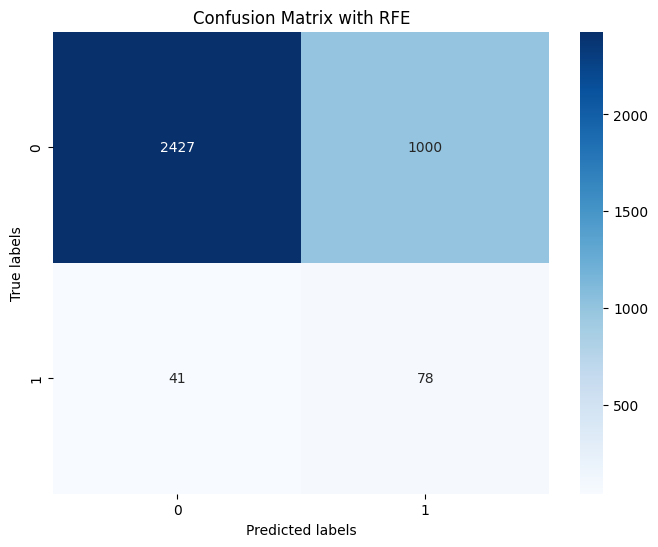

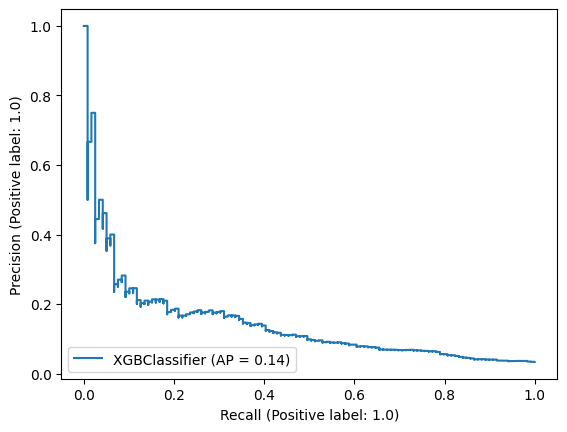

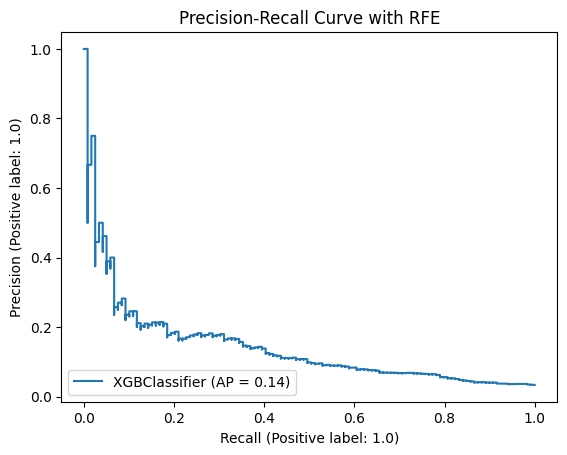


Top 13 Features Selected with XGBoost Importance:
1. Var28_woe - Importance: 0.2643616795539856
2. Var11_woe - Importance: 0.14273051917552948
3. Var29_woe - Importance: 0.07784630358219147
4. loan_desc_woe - Importance: 0.04386519640684128
5. Var12_woe - Importance: 0.04356112703680992
6. Var14_woe - Importance: 0.03970429673790932
7. Var17_1_woe - Importance: 0.03831322491168976
8. Var26_q_woe - Importance: 0.0363372340798378
9. idi_ratio_woe - Importance: 0.035165902227163315
10. Var25_q_woe - Importance: 0.03486126661300659
11. Var8_q_woe - Importance: 0.03472336381673813
12. income_woe - Importance: 0.03382673114538193
13. Var5_woe - Importance: 0.033332761377096176

Remaining Features:
['Var3_woe', 'Var27_woe', 'working_months_1_woe', 'ii_ratio_woe', 'Var4_woe']


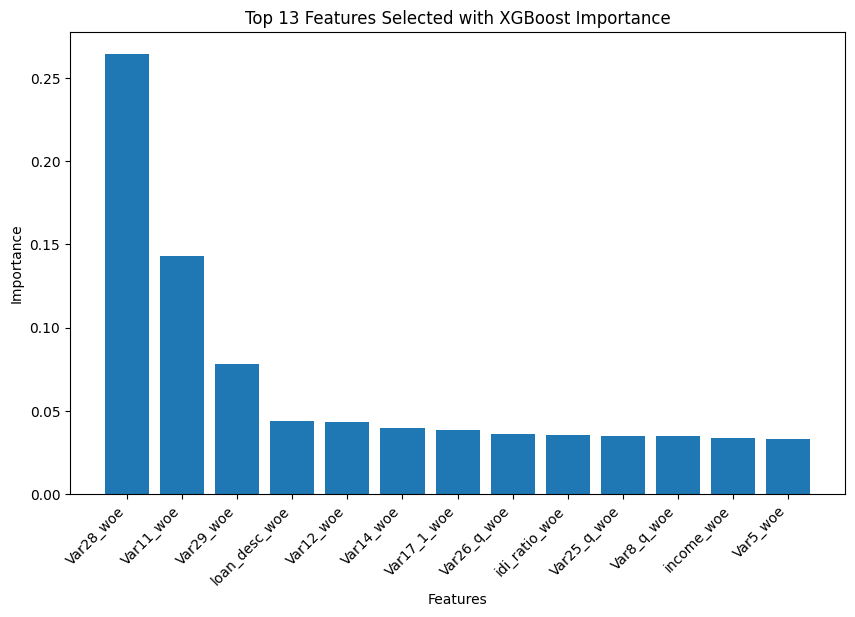


Number of features selected with XGBoost Importance: 13


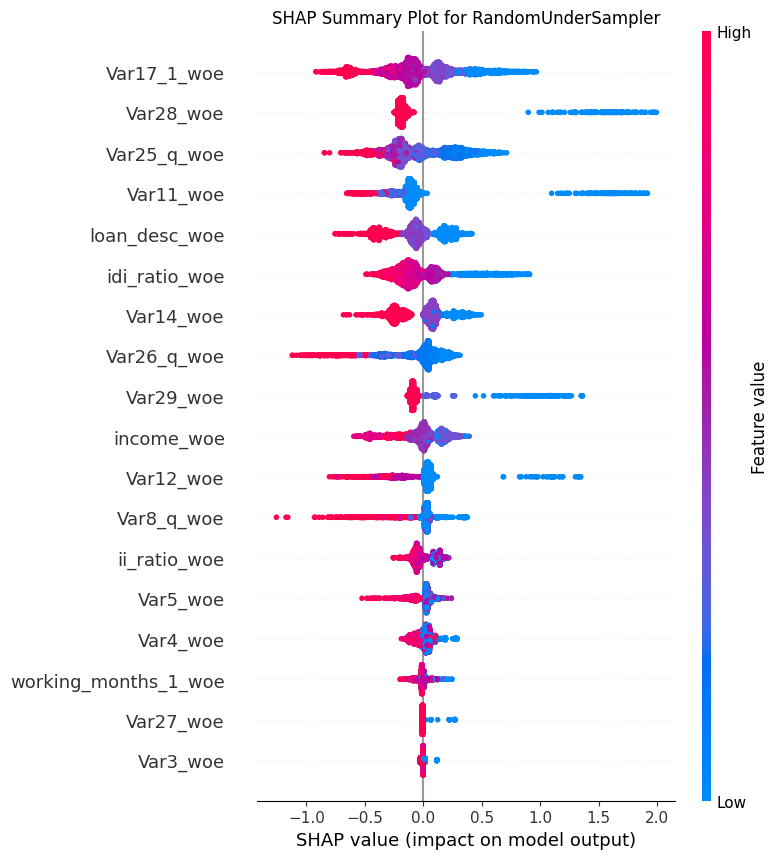


AUC-ROC Score with XGBoost: 0.7392738828825958


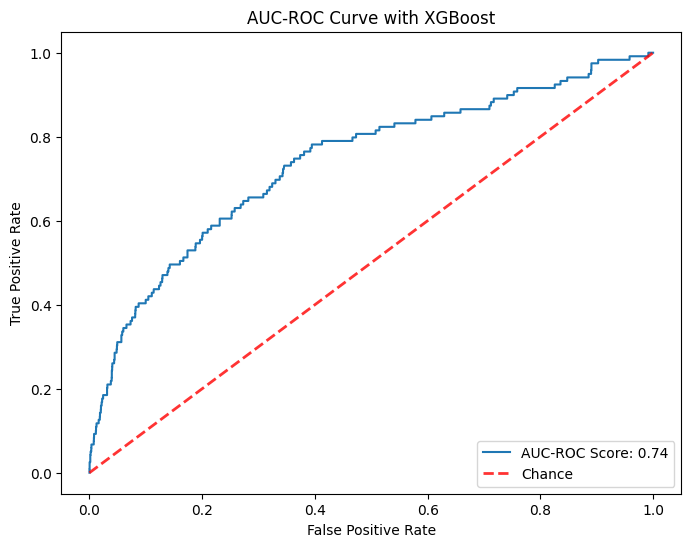

Fitting 3 folds for each of 192 candidates, totalling 576 fits

Best Parameters for NearMiss with RFE: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1.2, 'subsample': 0.8}

Classification Report with RFE:
              precision    recall  f1-score   support

         0.0       0.97      0.16      0.27      3427
         1.0       0.03      0.87      0.07       119

    accuracy                           0.18      3546
   macro avg       0.50      0.52      0.17      3546
weighted avg       0.94      0.18      0.27      3546



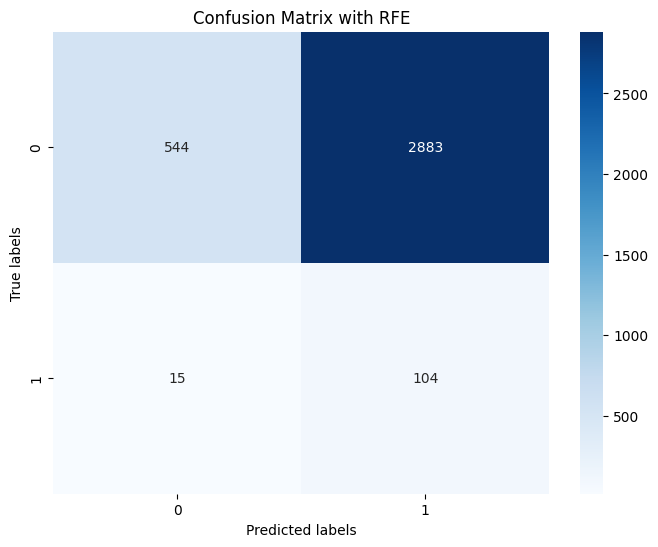

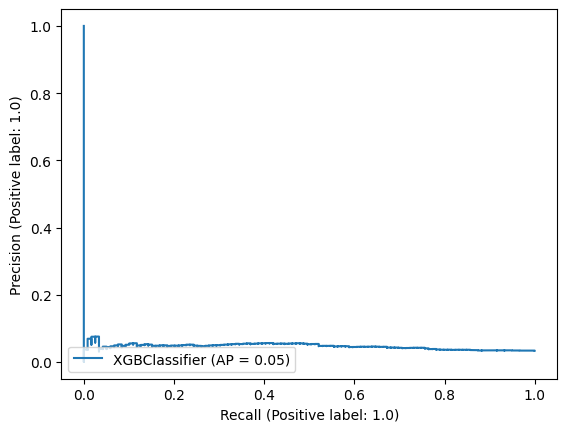

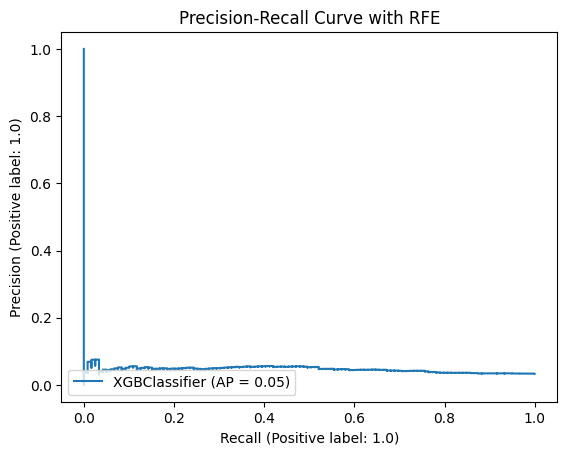


Top 13 Features Selected with XGBoost Importance:
1. Var28_woe - Importance: 0.20674583315849304
2. Var29_woe - Importance: 0.20059138536453247
3. Var12_woe - Importance: 0.167373389005661
4. Var3_woe - Importance: 0.1351335495710373
5. Var5_woe - Importance: 0.0454399399459362
6. idi_ratio_woe - Importance: 0.0321650393307209
7. Var17_1_woe - Importance: 0.028772449120879173
8. income_woe - Importance: 0.027103029191493988
9. Var11_woe - Importance: 0.022437794134020805
10. Var25_q_woe - Importance: 0.02125123329460621
11. Var8_q_woe - Importance: 0.01965312659740448
12. working_months_1_woe - Importance: 0.01801036112010479
13. loan_desc_woe - Importance: 0.017121100798249245

Remaining Features:
['Var27_woe', 'Var4_woe', 'Var14_woe', 'ii_ratio_woe', 'Var26_q_woe']


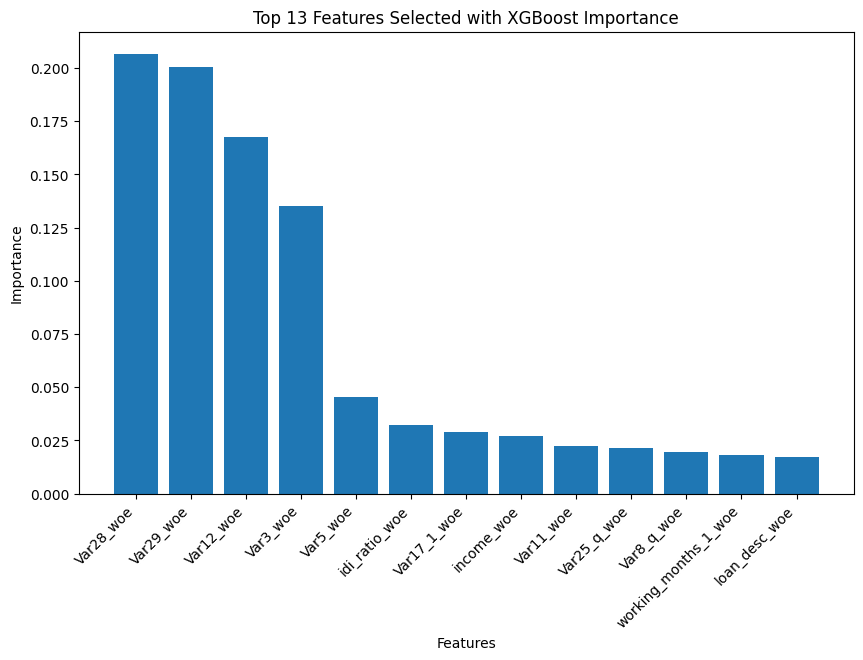


Number of features selected with XGBoost Importance: 13


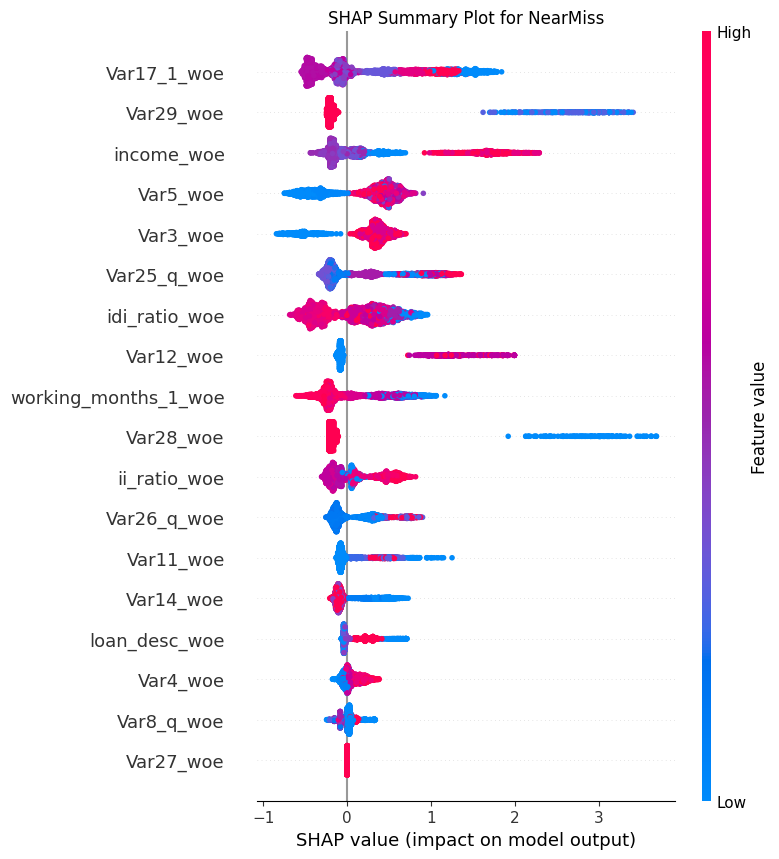


AUC-ROC Score with XGBoost: 0.5958245568434553


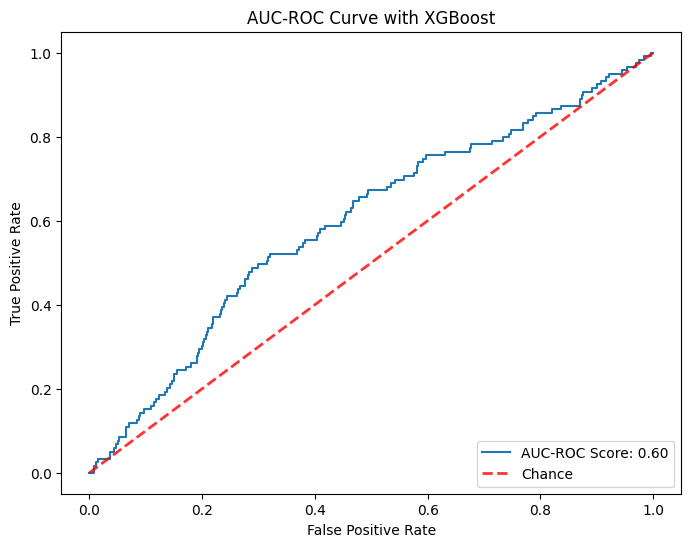


Combined Results for all Oversamplers with RFE (XGBoost Classifier):
     RandomUnderSampler                                                     \
    param_learning_rate param_n_estimators param_max_depth param_subsample   
27                  0.3                 25               3             0.8   
49                  0.4                 25               3             0.8   
25                  0.3                 25               3             0.8   
29                  0.3                 50               3             0.8   
101                 0.2                 50               3             0.8   
..                  ...                ...             ...             ...   
84                  0.5                 50               5             0.5   
184                 0.5                 25               7             0.5   
190                 0.5                 50               7             0.5   
188                 0.5                 50               7             0

In [208]:
results_dict_xgb = {}
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_t_scaled = scaler.transform(X_t)


for name, oversampler in oversamplers.items():
    # Upsample the minority class using the current oversampler
    X_resampled, y_resampled = oversampler.fit_resample(X_train_scaled, y_train)

    # Initialize XGBoost classifier
    xgb_clf = XGBClassifier(random_state=123, n_jobs=-1, objective='binary:logistic')

    # Fit XGBoost on the resampled data
    xgb_clf.fit(X_resampled, y_resampled)

    # Get feature importances
    feature_importances = xgb_clf.feature_importances_

    # Get indices of top 13 features
    top_indices = np.argsort(feature_importances)[::-1][:13]

    # Subset the data with top 13 features
    X_resampled_selected = X_resampled#[:, top_indices]
    X_t_scaled_selected = X_t_scaled#[:, top_indices]

    # Initialize GridSearchCV with XGBoost and verbose for detailed progress
    grid_search = GridSearchCV(xgb_clf, param_grid_xgb, cv=3, scoring='roc_auc', n_jobs=-1, verbose=4)

    # Fit GridSearchCV on the training data with selected features
    grid_search.fit(X_resampled_selected, y_resampled)

    # Get the best parameters
    best_params_xgb = grid_search.best_params_
    print(f"\nBest Parameters for {name} with RFE:", best_params_xgb)

    # Store results in dictionary
    results_xgb = pd.DataFrame(grid_search.cv_results_)
    cols_to_keep_xgb = ['param_learning_rate', 'param_n_estimators', 'param_max_depth','param_subsample','param_colsample_bytree', 'mean_test_score', 'std_test_score']
    results_table_xgb = results_xgb[cols_to_keep_xgb].sort_values(by='mean_test_score', ascending=False)
    results_dict_xgb[name] = results_table_xgb

    # Get the best performing model
    best_xgb_model = XGBClassifier(**best_params_xgb, random_state=123, n_jobs=-1)
    best_xgb_model.fit(X_resampled_selected, y_resampled)

    # Print classification report
    print("\nClassification Report with RFE:")
    y_pred_xgb = best_xgb_model.predict(X_t_scaled_selected)
    print(classification_report(y_t, y_pred_xgb))

    # Plot Confusion Matrix
    cm_xgb = confusion_matrix(y_t, y_pred_xgb)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix with RFE')
    plt.show()

    # Plot Precision-Recall Curve
    pr_display = PrecisionRecallDisplay.from_estimator(best_xgb_model, X_t_scaled_selected, y_t)
    pr_display.plot()
    plt.title('Precision-Recall Curve with RFE')
    plt.show()

    print(f"\nTop 13 Features Selected with XGBoost Importance:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {X.columns[idx]} - Importance: {feature_importances[idx]}")

    # Append the remaining columns
    remaining_features = list(set(X.columns) - set(X.columns[top_indices]))
    print("\nRemaining Features:")
    print(remaining_features)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(top_indices)), feature_importances[top_indices], align='center')
    plt.xticks(range(len(top_indices)), X.columns[top_indices], rotation=45, ha='right')
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Top 13 Features Selected with XGBoost Importance")
    plt.show()

    n_features_selected = len(top_indices)
    print(f"\nNumber of features selected with XGBoost Importance: {n_features_selected}")

    # Update results_dict_xgb with the top feature importance scores
    # top_feature_importances = feature_importances[top_indices]
    #top_features_df = pd.DataFrame({
    #    'Feature': X.columns[top_indices],
    #    'Importance': top_feature_importances
    #})
    #results_dict_xgb[name] = top_features_df

    # Calculate SHAP values
    explainer = shap.TreeExplainer(best_xgb_model)
    shap_values = explainer.shap_values(X_t_scaled_selected)

    # Plot SHAP summary plot
    shap.summary_plot(shap_values, X_t_scaled_selected, feature_names=X.columns, show=False)
    plt.title(f'SHAP Summary Plot for {name}')
    plt.tight_layout()
    plt.show()

    # Calculate AUC-ROC
    y_prob_xgb = best_xgb_model.predict_proba(X_t_scaled_selected)[:, 1]
    auc_roc_xgb = roc_auc_score(y_t, y_prob_xgb)
    print(f"\nAUC-ROC Score with XGBoost: {auc_roc_xgb}")

    # Plot AUC-ROC Curve
    fpr, tpr, thresholds = roc_curve(y_t, y_prob_xgb)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC-ROC Score: {auc_roc_xgb:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve with XGBoost')
    plt.legend(loc="lower right")
    plt.show()
# Combine results for all oversamplers into a single table
combined_results_xgb = pd.concat(results_dict_xgb, axis=1)

# Print the combined results
print("\nCombined Results for all Oversamplers with RFE (XGBoost Classifier):")
print(combined_results_xgb)

In [78]:
param_grid_svc = {
    'C': [1],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]
}

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best Parameters for RandomUnderSampler: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.68      0.80      3427
         1.0       0.06      0.61      0.11       119

    accuracy                           0.68      3546
   macro avg       0.52      0.64      0.46      3546
weighted avg       0.95      0.68      0.78      3546



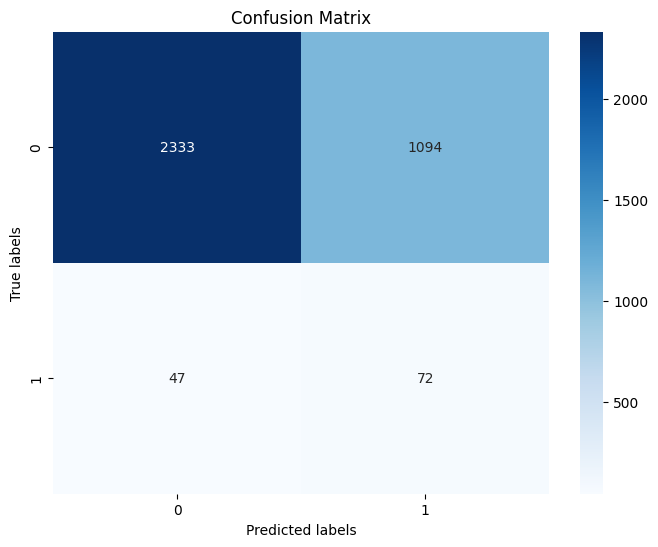

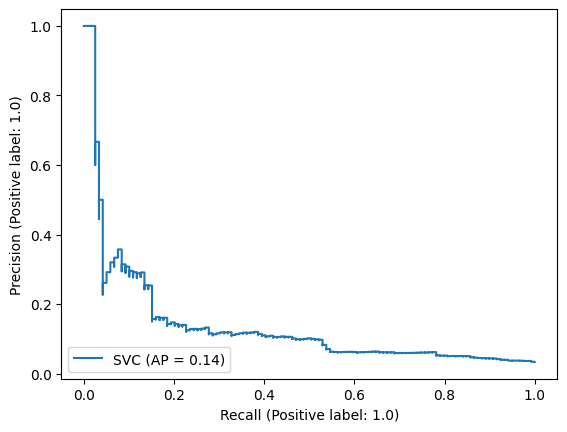

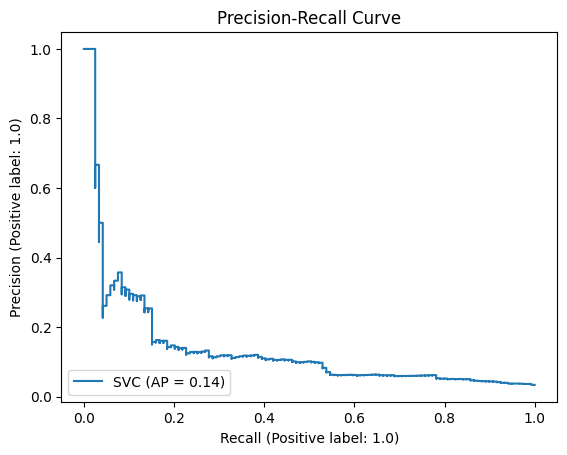

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best Parameters for NearMiss: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.24      0.38      3427
         1.0       0.04      0.87      0.07       119

    accuracy                           0.26      3546
   macro avg       0.51      0.56      0.23      3546
weighted avg       0.95      0.26      0.37      3546



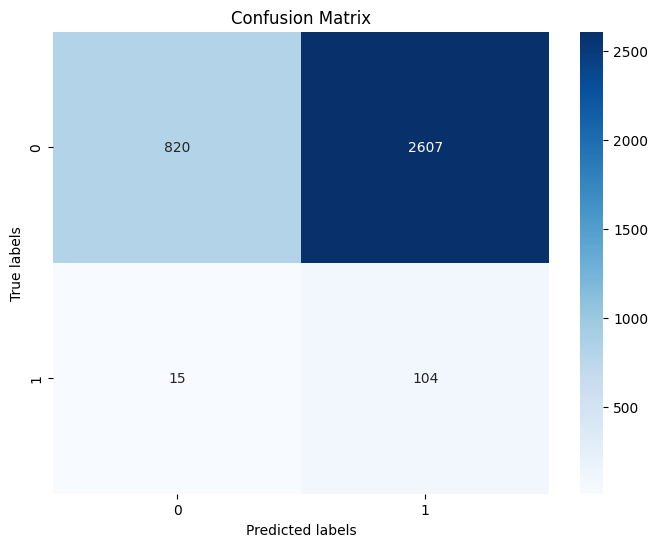

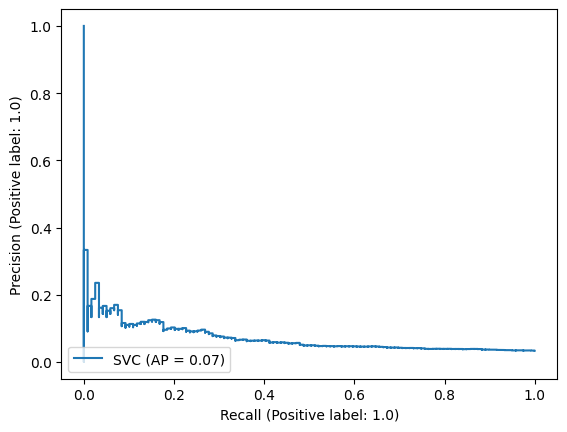

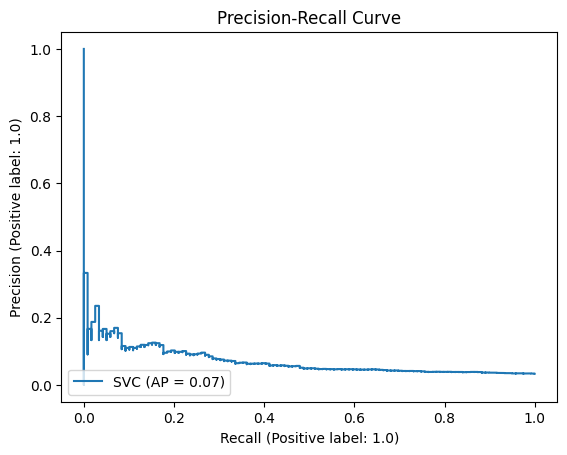


Combined Results for all Oversamplers (Support Vector Classifier):
   RandomUnderSampler                                NearMiss                  \
              param_C mean_test_score std_test_score  param_C mean_test_score   
1                   1        0.679595       0.022196        1        0.889694   
13                  1        0.679595       0.022196        1        0.889694   
7                   1        0.679595       0.022196        1        0.889694   
16                  1        0.675192       0.023291        1        0.889223   
4                   1        0.675192       0.023291        1        0.889223   
10                  1        0.675192       0.023291        1        0.889223   
0                   1        0.670714       0.011464        1        0.877220   
15                  1        0.670714       0.011464        1        0.877220   
12                  1        0.670714       0.011464        1        0.877220   
9                   1        0.670714    

In [139]:
results_dict_svc = {}
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_t_scaled = scaler.transform(X_t)

for name, oversampler in oversamplers.items():
    # Upsample the minority class using the current oversampler
    X_resampled, y_resampled = oversampler.fit_resample(X_train_scaled, y_train)

    # Initialize Support Vector Classifier
    svc_clf = SVC(random_state=123, class_weight = {0:1, 1:1.25})

    # Initialize GridSearchCV with SVC and verbose for detailed progress
    grid_search = GridSearchCV(svc_clf, param_grid_svc, cv=3, scoring='f1_macro', n_jobs=-1, verbose=4)

    # Fit GridSearchCV on the training data
    grid_search.fit(X_resampled, y_resampled)

    # Get the best parameters
    best_params_svc = grid_search.best_params_
    print(f"\nBest Parameters for {name}:", best_params_svc)

    # Store results in dictionary
    results_svc = pd.DataFrame(grid_search.cv_results_)
    cols_to_keep_svc = ['param_C','mean_test_score', 'std_test_score']
    results_table_svc = results_svc[cols_to_keep_svc].sort_values(by='mean_test_score', ascending=False)
    results_dict_svc[name] = results_table_svc

    # Get the best performing model
    best_svc_model = SVC(**best_params_svc,class_weight = {0:1, 1:1.25},random_state=123)
    best_svc_model.fit(X_resampled, y_resampled)

    # Print classification report
    print("\nClassification Report:")
    y_pred_svc = best_svc_model.predict(X_t_scaled)
    print(classification_report(y_t, y_pred_svc))

    # Plot Confusion Matrix
    cm_svc = confusion_matrix(y_t, y_pred_svc)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    pr_display = PrecisionRecallDisplay.from_estimator(best_svc_model, X_t_scaled, y_t)
    pr_display.plot()
    plt.title('Precision-Recall Curve')
    plt.show()

# Combine results for all oversamplers into a single table
combined_results_svc = pd.concat(results_dict_svc, axis=1)

# Print the combined results
print("\nCombined Results for all Oversamplers (Support Vector Classifier):")
print(combined_results_svc)

In [62]:
param_grid_rf = {
    'n_estimators': [200,400],
    'max_depth': [13],
    'min_samples_split': [25,50],
    'max_features' : ['auto', 'sqrt'],
    #'min_samples_leaf': [10,20]
    'bootstrap' : [True, False]
}

Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



Best Parameters for RandomUnderSampler: {'bootstrap': False, 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 25, 'n_estimators': 200}

Classification Report:


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85      3427
         1.0       0.08      0.58      0.13       119

    accuracy                           0.75      3546
   macro avg       0.53      0.67      0.49      3546
weighted avg       0.95      0.75      0.83      3546



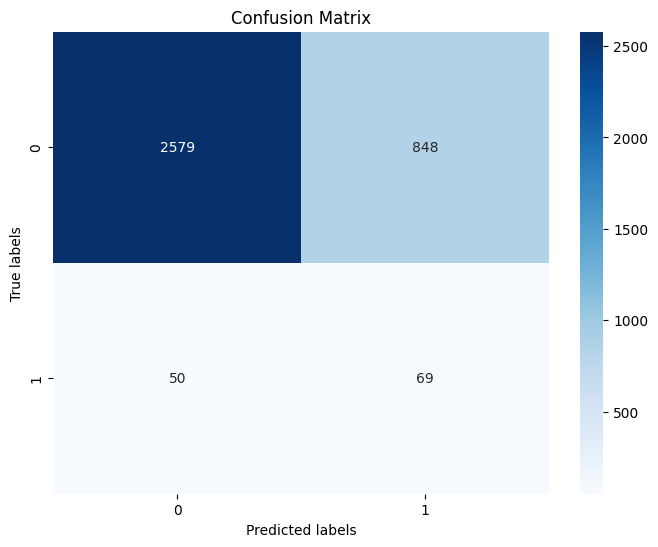

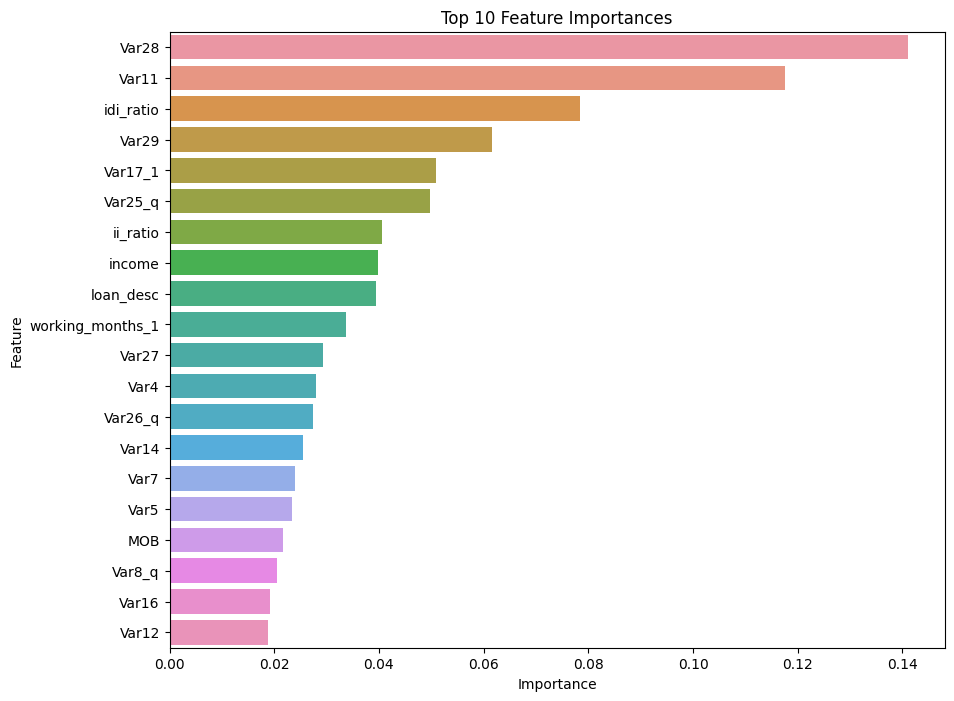

Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(



Best Parameters for NearMiss: {'bootstrap': False, 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 25, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.21      0.35      3427
         1.0       0.04      0.87      0.07       119

    accuracy                           0.23      3546
   macro avg       0.51      0.54      0.21      3546
weighted avg       0.95      0.23      0.34      3546



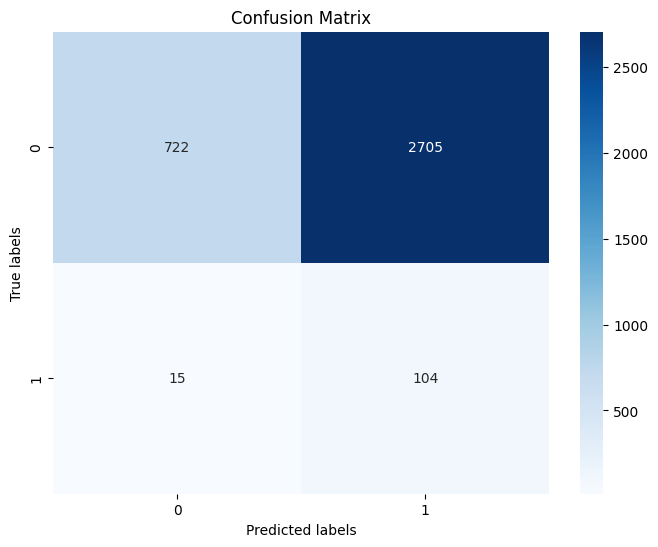

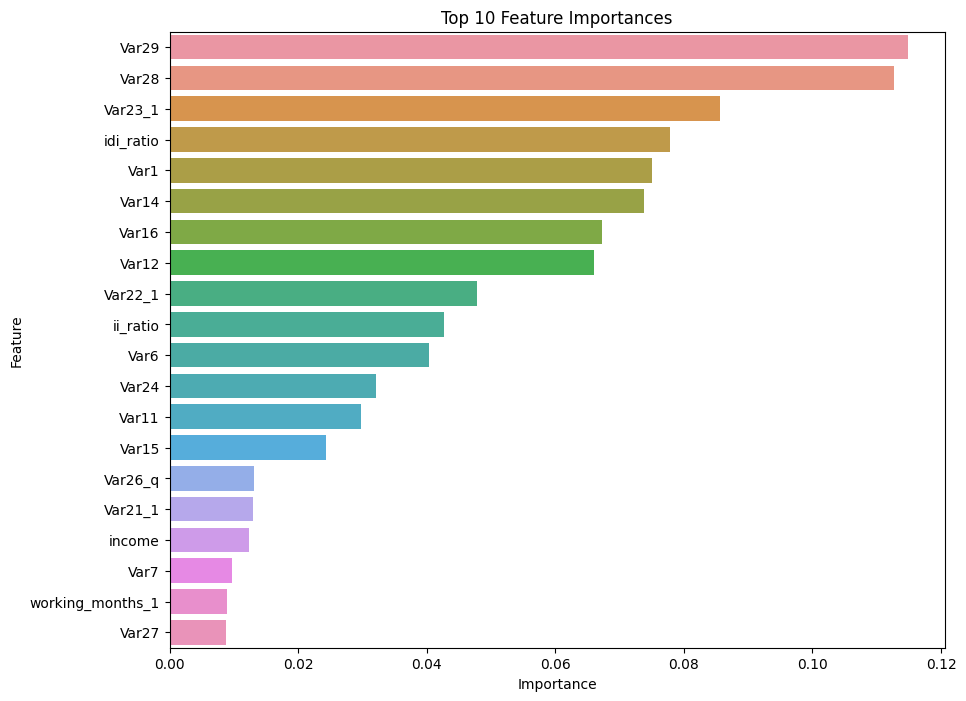


Combined Results for all Oversamplers (Random Forest Classifier):
   RandomUnderSampler                                                          \
   param_n_estimators param_max_depth param_min_samples_split param_bootstrap   
8                 200              13                      25           False   
12                200              13                      25           False   
1                 400              13                      25            True   
5                 400              13                      25            True   
10                200              13                      50           False   
14                200              13                      50           False   
9                 400              13                      25           False   
13                400              13                      25           False   
0                 200              13                      25            True   
4                 200              13     

In [98]:
results_dict_rf = {}
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_t_scaled = scaler.transform(X_t)

for name, oversampler in oversamplers.items():
    # Upsample the minority class using the current oversampler
    X_resampled, y_resampled = oversampler.fit_resample(X_train_scaled, y_train)

    # Initialize Random Forest Classifier
    rf_clf = RandomForestClassifier(random_state=123, n_jobs=-1)

    # Initialize GridSearchCV with Random Forest and verbose for detailed progress
    grid_search = GridSearchCV(rf_clf, param_grid_rf, cv=3, scoring='f1_macro', n_jobs=-1, verbose=4)

    # Fit GridSearchCV on the training data
    grid_search.fit(X_resampled, y_resampled)

    # Get the best parameters
    best_params_rf = grid_search.best_params_
    print(f"\nBest Parameters for {name}:", best_params_rf)

    # Store results in dictionary
    results_rf = pd.DataFrame(grid_search.cv_results_)
    cols_to_keep_rf = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split','param_bootstrap','param_max_features','mean_test_score', 'std_test_score']
    results_table_rf = results_rf[cols_to_keep_rf].sort_values(by='mean_test_score', ascending=False)
    results_dict_rf[name] = results_table_rf

    # Get the best performing model
    best_rf_model = RandomForestClassifier(**best_params_rf, random_state=123, n_jobs=-1)
    best_rf_model.fit(X_resampled, y_resampled)

    # Print classification report
    print("\nClassification Report:")
    y_pred_rf = best_rf_model.predict(X_t_scaled)
    print(classification_report(y_t, y_pred_rf))

    # Plot Confusion Matrix
    cm_rf = confusion_matrix(y_t, y_pred_rf)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate Feature Importances
    feature_importances = best_rf_model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot Feature Importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df[:20])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 10 Feature Importances')
    plt.show()

# Combine results for all oversamplers into a single table
combined_results_rf = pd.concat(results_dict_rf, axis=1)

# Print the combined results
print("\nCombined Results for all Oversamplers (Random Forest Classifier):")
print(combined_results_rf)


In [11]:
param_grid_dt = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best Parameters for SMOTE: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      3427
         1.0       0.13      0.18      0.15       119

    accuracy                           0.93      3546
   macro avg       0.55      0.57      0.56      3546
weighted avg       0.94      0.93      0.94      3546



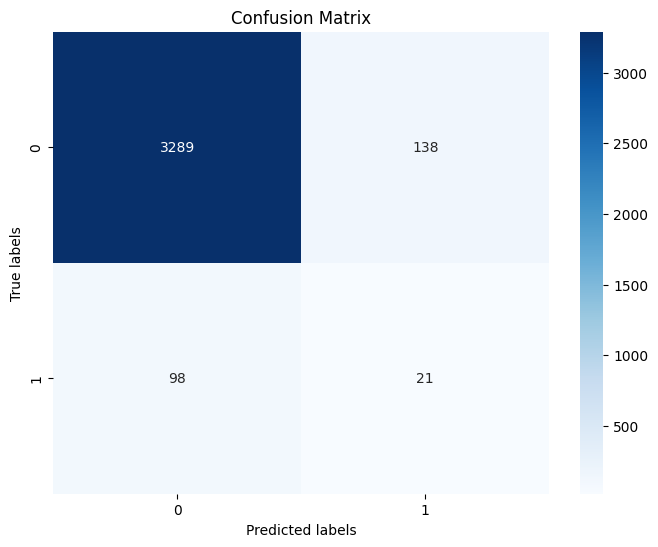

Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best Parameters for RandomOverSampler: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90      3427
         1.0       0.07      0.36      0.12       119

    accuracy                           0.82      3546
   macro avg       0.52      0.60      0.51      3546
weighted avg       0.94      0.82      0.88      3546



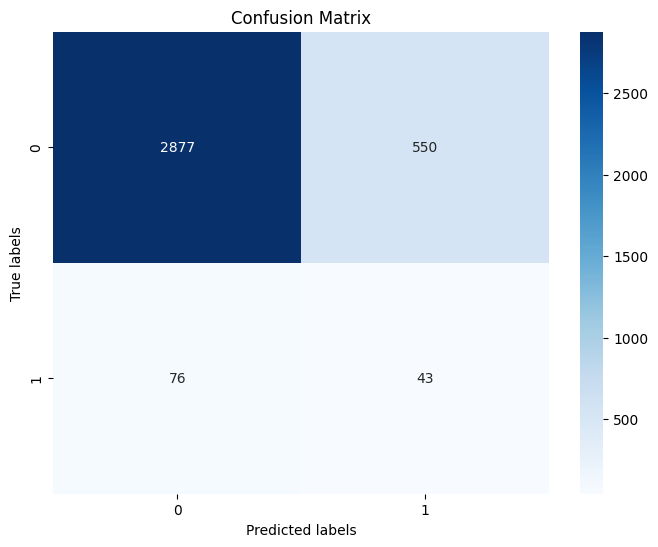

Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best Parameters for ADASYN: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87      3427
         1.0       0.05      0.34      0.09       119

    accuracy                           0.78      3546
   macro avg       0.51      0.57      0.48      3546
weighted avg       0.94      0.78      0.85      3546



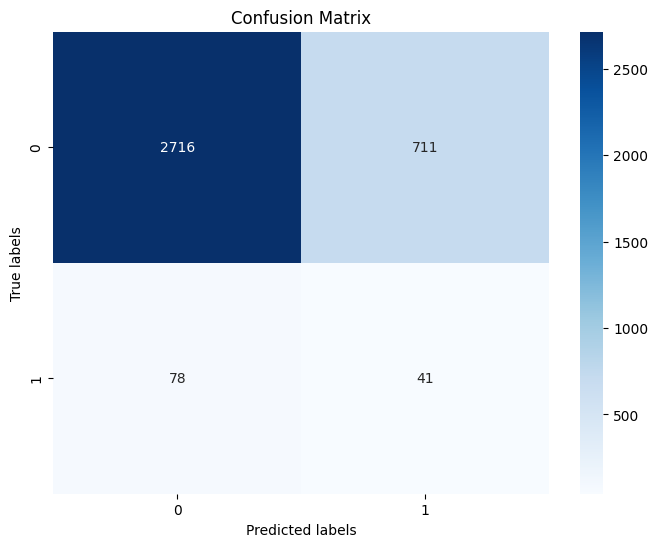


Combined Results for all Oversamplers (Decision Tree Classifier):
             SMOTE                                                 \
   param_max_depth param_min_samples_split param_min_samples_leaf   
23               7                      10                      2   
21               7                       2                      2   
20               7                      10                      1   
22               7                       5                      2   
18               7                       2                      1   
26               7                      10                      4   
19               7                       5                      1   
25               7                       5                      4   
24               7                       2                      4   
12               5                       2                      2   
13               5                       5                      2   
10               5                  

In [17]:
results_dict_dt = {}
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_t_scaled = scaler.transform(X_t)

for name, oversampler in oversamplers.items():
    # Upsample the minority class using the current oversampler
    X_resampled, y_resampled = oversampler.fit_resample(X_train_scaled, y_train)

    # Initialize Decision Tree Classifier
    dt_clf = DecisionTreeClassifier(random_state=123)

    # Initialize GridSearchCV with Decision Tree and verbose for detailed progress
    grid_search = GridSearchCV(dt_clf, param_grid_dt, cv=3, scoring=f05_scorer, n_jobs=-1, verbose=4)

    # Fit GridSearchCV on the training data
    grid_search.fit(X_resampled, y_resampled)

    # Get the best parameters
    best_params_dt = grid_search.best_params_
    print(f"\nBest Parameters for {name}:", best_params_dt)

    # Store results in dictionary
    results_dt = pd.DataFrame(grid_search.cv_results_)
    cols_to_keep_dt = ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score', 'std_test_score']
    results_table_dt = results_dt[cols_to_keep_dt].sort_values(by='mean_test_score', ascending=False)
    results_dict_dt[name] = results_table_dt

    # Get the best performing model
    best_dt_model = DecisionTreeClassifier(**best_params_dt, random_state=123)
    best_dt_model.fit(X_resampled, y_resampled)

    # Print classification report
    print("\nClassification Report:")
    y_pred_dt = best_dt_model.predict(X_t_scaled)
    print(classification_report(y_t, y_pred_dt))

    # Plot Confusion Matrix
    cm_dt = confusion_matrix(y_t, y_pred_dt)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Combine results for all oversamplers into a single table
combined_results_dt = pd.concat(results_dict_dt, axis=1)

# Print the combined results
print("\nCombined Results for all Oversamplers (Decision Tree Classifier):")
print(combined_results_dt)


Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters for SMOTE: {'C': 1.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      3427
         1.0       0.09      0.62      0.15       119

    accuracy                           0.76      3546
   macro avg       0.53      0.70      0.51      3546
weighted avg       0.95      0.76      0.84      3546



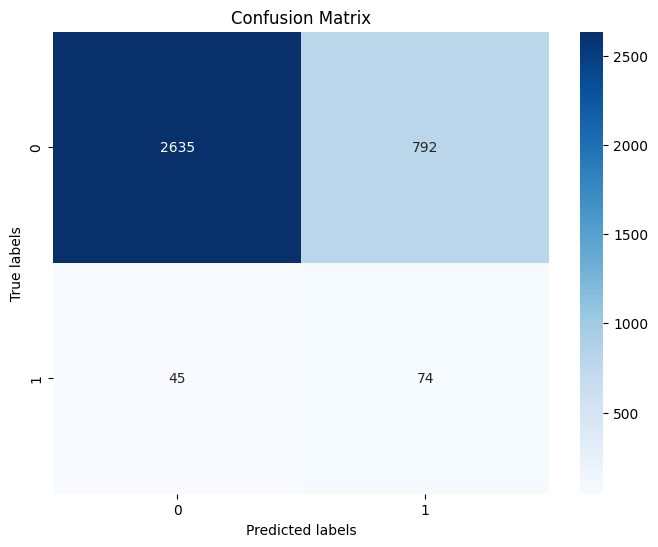

Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Best Parameters for RandomOverSampler: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.87      3427
         1.0       0.09      0.62      0.16       119

    accuracy                           0.78      3546
   macro avg       0.54      0.70      0.52      3546
weighted avg       0.95      0.78      0.85      3546



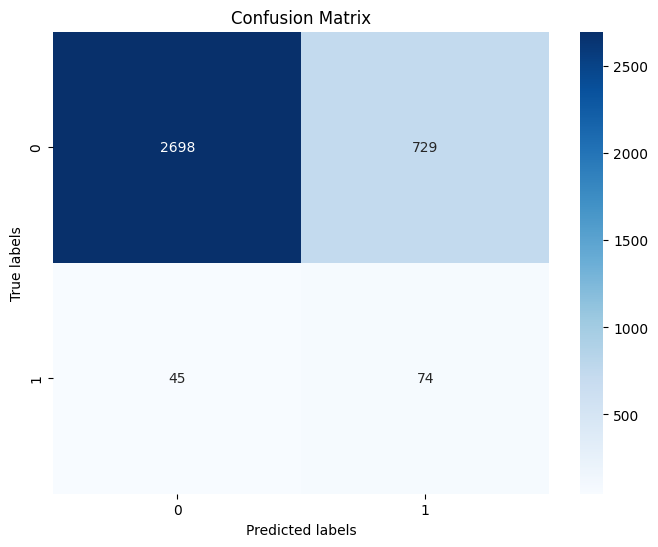

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters for ADASYN: {'C': 0.9, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.74      0.85      3427
         1.0       0.08      0.65      0.14       119

    accuracy                           0.74      3546
   macro avg       0.53      0.69      0.49      3546
weighted avg       0.95      0.74      0.82      3546



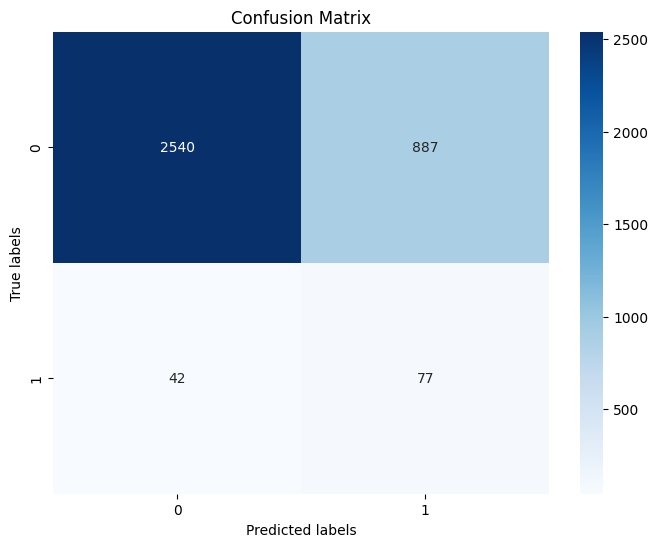


Combined Results for all Oversamplers:


NameError: name 'combined_results' is not defined

In [12]:
log_reg = LogisticRegression(random_state=123, max_iter=1000)  # Increase max_iter

# Create a dictionary to store results for each oversampler
results_dict = {}
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

#percentile_value = np.percentile(X_train['ii_ratio'][~np.isinf(X_train['ii_ratio'])], 95)
#X_train.loc[np.isinf(X_train['ii_ratio']), 'ii_ratio'] = percentile_value
#X_test.loc[np.isinf(X_test['ii_ratio']), 'ii_ratio'] = percentile_value
#X_t.loc[np.isinf(X_t['ii_ratio']), 'ii_ratio'] = percentile_value

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_t_scaled = scaler.transform(X_t)
for name, oversampler in oversamplers.items():


    # Upsample the minority class using the current oversampler
    X_resampled, y_resampled = oversampler.fit_resample(X_train_scaled, y_train)

    logreg = LogisticRegression()

    # Initialize GridSearchCV with verbose for detailed progress
    grid_search = GridSearchCV(logreg, param_grid, cv=3, scoring=f05_scorer, n_jobs=-1, verbose=4)

    # Fit GridSearchCV on the training data
    grid_search.fit(X_resampled, y_resampled)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"\nBest Parameters for {name}:", best_params)

    # Store results in dictionary
    results = pd.DataFrame(grid_search.cv_results_)
    cols_to_keep = ['param_C', 'param_penalty', 'param_solver', 'param_class_weight', 'mean_test_score', 'std_test_score']
    results_table = results[cols_to_keep].sort_values(by='mean_test_score', ascending=False)
    results_dict[name] = results_table

    # Get the best performing model
    best_logreg = LogisticRegression(**best_params, max_iter=1000,random_state=123, n_jobs=-1) 
    best_logreg.fit(X_resampled, y_resampled)

      

    # Print classification report
    print("\nClassification Report:")
    y_pred = best_logreg.predict(X_t_scaled)
    print(classification_report(y_t, y_pred))

    cm = confusion_matrix(y_t, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
# Combine results for all oversamplers into a single table
combined_results_logreg = pd.concat(results_dict, axis=1)

# Print the combined results
print("\nCombined Results for all Oversamplers:")
print(combined_results_logreg)


In [7]:
param_grid_bagg = {
    'n_estimators': [100, 200],  # Number of base estimators
    'max_samples': [0.5,1.0],  # Proportion of samples to draw from X to train each base estimator
    'max_features': [0.8],  # Proportion of features to draw from X to train each base estimator
    'bootstrap': [False],  # Whether samples are drawn with replacement
    'bootstrap_features': [False]  # Whether features are drawn with replacement
    #'base_estimator__max_depth': [3, 5, 7, None],  # Max depth of the base estimator (e.g., DecisionTreeClassifier)
    # Add more parameters as needed
}

Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Best Parameters for SMOTE: {'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 200}


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      3427
         1.0       0.08      0.57      0.14       119

    accuracy                           0.77      3546
   macro avg       0.53      0.67      0.50      3546
weighted avg       0.95      0.77      0.84      3546



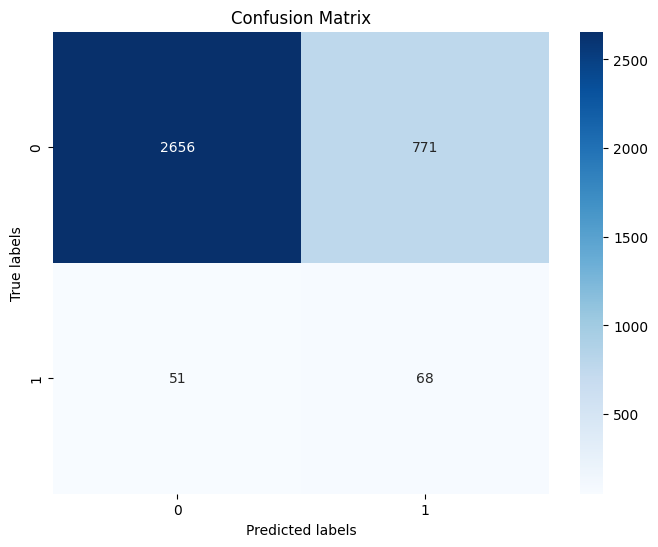

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [10]:
log_reg = LogisticRegression(C= 1, penalty= 'l2', solver= 'saga', max_iter = 1000)  # Increase max_iter

# Create a dictionary to store results for each oversampler
results_dict = {}
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

percentile_value = np.percentile(X_train['ii_ratio'][~np.isinf(X_train['ii_ratio'])], 95)
X_train.loc[np.isinf(X_train['ii_ratio']), 'ii_ratio'] = percentile_value
X_test.loc[np.isinf(X_test['ii_ratio']), 'ii_ratio'] = percentile_value
X_t.loc[np.isinf(X_t['ii_ratio']), 'ii_ratio'] = percentile_value

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_t_scaled = scaler.transform(X_t)

for name, oversampler in oversamplers.items():
    # Upsample the minority class using the current oversampler
    X_resampled, y_resampled = oversampler.fit_resample(X_train_scaled, y_train)

    bagging_logreg = BaggingClassifier(base_estimator=log_reg, random_state=123, n_jobs=-1)

    # Initialize GridSearchCV with verbose for detailed progress
    grid_search = GridSearchCV(bagging_logreg, param_grid_bagg, cv=3, scoring=f05_scorer, n_jobs=-1, verbose=4)

    # Fit GridSearchCV on the training data
    grid_search.fit(X_resampled, y_resampled)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"\nBest Parameters for {name}:", best_params)

    # Store results in dictionary
    results = pd.DataFrame(grid_search.cv_results_)
    cols_to_keep = ['param_n_estimators', 'param_max_samples','mean_test_score', 'std_test_score']
    results_table = results[cols_to_keep].sort_values(by='mean_test_score', ascending=False)
    results_dict[name] = results_table

    # Get the best performing model
    best_bagging_logreg = BaggingClassifier(**best_params,
                                            base_estimator=log_reg, 
                                            random_state=123, n_jobs=-1)
    best_bagging_logreg.fit(X_resampled, y_resampled)

      

    # Print classification report
    print("\nClassification Report:")
    y_pred = best_bagging_logreg.predict(X_t_scaled)
    print(classification_report(y_t, y_pred))

    cm = confusion_matrix(y_t, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
# Combine results for all oversamplers into a single table
combined_results = pd.concat(results_dict, axis=1)

# Print the combined results
print("\nCombined Results for all Oversamplers:")
print(combined_results)



In [ ]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    #'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    #'subsample': [0.8, 0.9, 1.0],
    #'colsample_bytree': [0.8, 0.9, 1.0],
    #'gamma': [0, 1, 5],
    #'reg_alpha': [0.0, 0.1, 0.5],
    #'reg_lambda': [0.0, 0.1, 0.5],
    'tree_method': ['gpu_hist'],  # Specify GPU usage
    'device' : ['cuda']
}

In [ ]:
percentile_value = np.percentile(X_train['ii_ratio'][~np.isinf(X_train['ii_ratio'])], 95)

In [ ]:

# Create a dictionary to store results for each oversampler
results_dict = {}
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
#imputer = SimpleImputer(strategy='mean')

X_train.loc[np.isinf(X_train['ii_ratio']), 'ii_ratio'] = percentile_value
X_test.loc[np.isinf(X_test['ii_ratio']), 'ii_ratio'] = percentile_value
X_t.loc[np.isinf(X_t['ii_ratio']), 'ii_ratio'] = percentile_value
#X_train_imputed = imputer.fit_transform(X_train)
#X_test_imputed = scaler.transform(X_test)
#X_t_imputed = scaler.transform(X_t)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_t_scaled = scaler.transform(X_t)

for name, oversampler in oversamplers.items():
    # Upsample the minority class using the current oversampler
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

    # Initialize XGBoost classifier
    xgb_clf = XGBClassifier(random_state=123, n_jobs=-1, objective='binary:logistic')
    
    # Initialize GridSearchCV with XGBoost and verbose for detailed progress
    grid_search = GridSearchCV(xgb_clf, param_grid_xgb, cv=3, scoring='f1', n_jobs=-1, verbose=4)

    # Fit GridSearchCV on the training data
    grid_search.fit(X_resampled, y_resampled)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"\nBest Parameters for {name}:", best_params)

    # Store results in dictionary
    results = pd.DataFrame(grid_search.cv_results_)
    cols_to_keep = ['param_learning_rate', 'param_max_depth', 'param_tree_method', 'mean_test_score', 'std_test_score']
    results_table = results[cols_to_keep].sort_values(by='mean_test_score', ascending=False)
    results_dict[name] = results_table

    # Get the best performing model
    best_xgb_model = XGBClassifier(**best_params, random_state=123, n_jobs=-1, tree_method='cuda')
    best_xgb_model.fit(X_resampled, y_resampled)

    # Make predictions on the test set
    y_pred_prob = best_xgb_model.predict_proba(X_test_scaled)
    
    # Compute pR AUC score
    pr_auc = pr_auc_score(y_test, y_pred_prob)
    print(f"\nModel Specifications and Validation pR AUC for {name}:")
    print(f"pR AUC Score: {pr_auc}")

    # Print classification report
    print("\nClassification Report:")
    y_pred = best_xgb_model.predict(X_t_scaled)
    print(classification_report(y_t, y_pred))

    cm = confusion_matrix(y_t, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
# Combine results for all oversamplers into a single table
combined_results = pd.concat(results_dict, axis=1)

# Print the combined results
print("\nCombined Results for all Oversamplers:")
print(combined_results)